## Regression Analysis import calls

In [1]:
import numpy as np
import pandas as pd
from itertools import combinations

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.decomposition import PCA

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

import os

## Prepare Data

In [2]:
def reconcile_filename_column(df):
    if 'filename' in df.keys():
        df.rename(columns={'filename': 'Filename'}, inplace=True)
    return df

def drop_txt(txt):
    if type(txt) == type(2):
        return txt
    else:
        return(txt.replace('.txt', ''))

def combine_psuedos_with_scores(df, scores_df):
    df = reconcile_filename_column(df)
    df['Filename'] = df['Filename'].apply(drop_txt).astype('int')
    scores_df['Psuedos'] = scores_df['Psuedos'].astype('int')

    combined_df = df.merge(scores_df, how='right', left_on='Filename', right_on='Psuedos')
    combined_df = combined_df.dropna()
    return combined_df

def create_X_y(df, scores_df):
    combined_df = combine_psuedos_with_scores(df, scores_df)

    response_var = combined_df['ChatGPT Percent Score']
    combined_df.drop(['Filename', 'Psuedos', 'ChatGPT Percent Score', 'Response Word Count'], axis=1, inplace=True)
    predictor_vars = combined_df

    return {'X': predictor_vars, 
            'y': response_var
    }

def load_dfs(base_dir, math=None):
    '''
    Takes base features and target and combines with some linguistic measures. 
    Scales features using StandardScaler()
    '''
    combined_scores_file_path = os.path.join(base_dir, 'data', 'combined_responses_scores_added.xlsx')
    scores_df = pd.read_excel(combined_scores_file_path, index_col=0)
    scores_df = scores_df[['Psuedos', 'ChatGPT Percent Score', 'Response Word Count', 'Course']]
    if math == None:
        scores_df = scores_df[scores_df['Course'] != 'MATH 111']
    
    scores_df = scores_df.drop(['Course'], axis=1)

    list_of_df_dicts = []

    for pred_name in ['taaco', 'taaled', 'taales', 'taassc']:
        temp_pred_results_file_path = os.path.join(base_dir, 'predictor_results', f'{pred_name}_results.csv')
        temp_df = pd.read_csv(temp_pred_results_file_path)

        temp_X_y_dict = create_X_y(temp_df, scores_df)

        scaled_X = temp_X_y_dict['X'].copy()
        scaler = StandardScaler()
        scaled_X = pd.DataFrame(scaler.fit_transform(scaled_X), columns=scaled_X.columns)

        temp_df_dict = {
            'name': pred_name, 
            'df': temp_df, 
            'X': scaled_X, 
            'y': temp_X_y_dict['y']
        }
        list_of_df_dicts.append(temp_df_dict)
    return [list_of_df_dicts, scores_df]

In [3]:
base_dir=os.getcwd()
list_of_df_dicts, scores_df = load_dfs(base_dir)

In [4]:
test_df_dict = list_of_df_dicts[0]
test_df = pd.DataFrame(test_df_dict['df'])
test_df_num_features = len(test_df.columns)-1

In [5]:
len(test_df)

171

In [6]:
model_conversion_dict = {
    'linear': LinearRegression(),
    'ridge': Ridge(),
    'lasso': Lasso()
}

## Feature Selection - Combinatorial Optimization

In [7]:
def create_all_feature_dicts(df, target, subset_n):
    features = df.keys()
    all_subsets = list(combinations(features, subset_n))

    list_of_feature_dicts = []
    name_index = 0
    for subset in all_subsets:
        temp_dict = {
            'name': f'model_{name_index}',
            'features': list(subset), 
            'reduced_df': df[list(subset)], 
            'target': target,
            'model': LinearRegression()
        }
        list_of_feature_dicts.append(temp_dict)
        name_index += 1

    return list_of_feature_dicts

def run_cross_val(dict, cv_n):
    model = dict['model']
    X = dict['reduced_df']
    y = dict['target']
    all_scores = cross_val_score(model, X, y, cv=cv_n)

    dict['cross_val_scores'] = all_scores
    dict['cross_val_avg'] = np.mean(all_scores)
    return dict

def return_selected_dict(list_of_dicts, name):
    selected_dict = list(filter(lambda model: model['name'] == name, list_of_dicts))[0]
    return selected_dict

In [8]:
#for df_dict in list_of_df_dicts:
#    list_of_cv_dicts = []

#    for model_type in ['linear', 'ridge', 'lasso']:
#        #for n_features in range(2, 10):
#        for n_features in range(2, 3):
#            temp_dict = run_model()
#            list_of_cv_dicts.append(temp_dict)

#    temp_df = pd.DataFrame(list_of_cv_dicts)
#    temp_df_name = df_dict['name']
#    cv_results_path = os.path.join(base_dir, 'dim_redux_results', f'{temp_df_name}.xlsx')
#    temp_df.to_excel(cv_results_path)

Brute force isn't going to work (could take 30+ centuries to run through it all), so we can do SelectKBest to determine which features to choose. 

## Feature Selection - SelectKBest

In [9]:
list_of_cat_cv_dicts = []

for df_dict in list_of_df_dicts:
    list_of_cv_dicts = []
    X = df_dict['X']
    y = df_dict['y']

    for model_type in ['linear', 'ridge', 'lasso']:
        model_reg = model_conversion_dict[model_type]

        for n_features in range(2, 18):
            fit_X = SelectKBest(f_regression, k=n_features).fit(X, y)
            X_new = fit_X.transform(X)
            feature_names = fit_X.get_feature_names_out()

            all_scores = cross_val_score(model_reg, X_new, y, cv=5)
            cross_val_avg = np.mean(all_scores)

            temp_dict = {
                'model_type': model_type, 
                'n_features': n_features, 
                'feature_names': feature_names, 
                'all_cv_scores': all_scores,
                'cross_val_avg': cross_val_avg
                }
            list_of_cv_dicts.append(temp_dict)

    temp_df = pd.DataFrame(list_of_cv_dicts)
    temp_df_name = df_dict['name']

    list_of_cat_cv_dicts.append({'df': temp_df, 'df_name': temp_df_name})

kbest_results_path = os.path.join(base_dir, 'dim_redux_results', f'kbest_all_categories.xlsx')

with pd.ExcelWriter(kbest_results_path, mode='a', if_sheet_exists='replace', engine='openpyxl') as writer:
    for final_dict in list_of_cat_cv_dicts:
        final_dict['df'].to_excel(writer, sheet_name=f'{final_dict["df_name"]}')


## Feature Projection - PCA

First, we'll use eigenvalues of the PCA to determine number of features to keep.

In [10]:
def create_scree_plot(df_dict, n_components):
    pca = PCA(n_components=n_components, svd_solver='full')
    pca_fit = pca.fit(df_dict['X'])

    pc_values = np.arange(pca.n_components_) + 1
    explained_var = [round(ex_var, 4) for ex_var in pca.explained_variance_]
    for index in range(0, len(explained_var)):
        if explained_var[index] < 1:
            num_of_pc = index+1
            print(f'Use first {num_of_pc} principal components')
            break

    plt.plot(pc_values, pca.explained_variance_, 'o-', linewidth=2, color='blue')
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Eigenvalues')
    plt.show()

    return num_of_pc

Use first 11 principal components


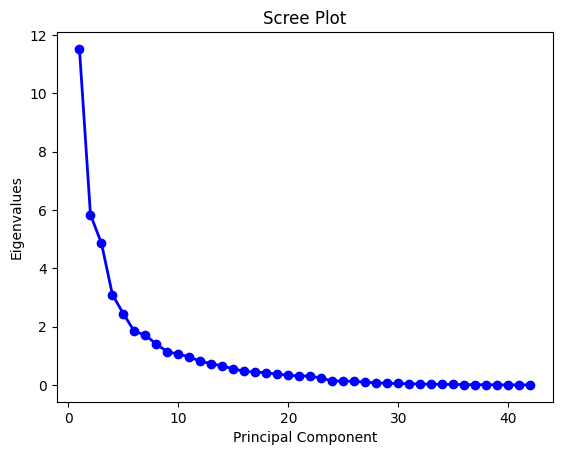

11

In [11]:
create_scree_plot(test_df_dict, test_df_num_features)

In [12]:
def perform_pca(df_dict, n_components):
    pca = PCA(n_components=n_components, svd_solver='full')
    new_X = pca.fit_transform(df_dict['X'])
    df_dict['full_X'] = df_dict['X']
    df_dict['X'] = new_X
    return df_dict

In [13]:
list_of_cat_cv_dicts = []

for df_dict in list_of_df_dicts:
    list_of_cv_dicts = []
    X = df_dict['X']
    y = df_dict['y']

    for model_type in ['linear', 'ridge', 'lasso']:
        model_reg = model_conversion_dict[model_type]

        for n_features in range(2, 19):
            temp_pca = PCA(n_components=n_features, svd_solver='full')
            X_new = temp_pca.fit_transform(X)

            all_scores = cross_val_score(model_reg, X_new, y, cv=5)
            cross_val_avg = np.mean(all_scores)

            temp_dict = {
                'model_type': model_type, 
                'n_features': n_features, 
                'all_cv_scores': all_scores,
                'cross_val_avg': cross_val_avg
                }
            list_of_cv_dicts.append(temp_dict)

    temp_df = pd.DataFrame(list_of_cv_dicts)
    temp_df_name = df_dict['name']

    list_of_cat_cv_dicts.append({'df': temp_df, 'df_name': temp_df_name})

pca_results_path = os.path.join(base_dir, 'dim_redux_results', f'pca_all_categories.xlsx')

with pd.ExcelWriter(pca_results_path, mode='a', if_sheet_exists='replace', engine='openpyxl') as writer:
    for final_dict in list_of_cat_cv_dicts:
        final_dict['df'].to_excel(writer, sheet_name=f'{final_dict["df_name"]}')

## Present Data

In [14]:
def extract_range(row, df):
    model_type = row['Model Type']
    reduced_df = df[df['model_type'] == model_type].copy()
    min_x_val_avg = reduced_df['cross_val_avg'].min()
    max_x_val_avg = reduced_df['cross_val_avg'].max()
    return f'[{round(min_x_val_avg, 3)}, {round(max_x_val_avg, 3)}]'

def print_ranges_table(df_path):
    # df with sheets for each set of features
    results_df = pd.DataFrame(['linear', 'ridge', 'lasso'], columns=['Model Type'])
    
    for sheet_name in ['taaco', 'taaled', 'taales', 'taassc']:
        temp_df = pd.read_excel(df_path, index_col=0, sheet_name=sheet_name)
        results_df[f'{sheet_name} X-Val Avg Rng'] = results_df.apply(extract_range, args=(temp_df,), axis=1)

    print(results_df)

In [15]:
print_ranges_table(kbest_results_path)

  Model Type taaco X-Val Avg Rng taaled X-Val Avg Rng taales X-Val Avg Rng  \
0     linear     [-0.505, -0.05]     [-0.335, -0.137]     [-0.511, -0.052]   
1      ridge    [-0.317, -0.042]      [-0.29, -0.127]     [-0.308, -0.052]   
2      lasso    [-0.076, -0.076]     [-0.076, -0.076]     [-0.076, -0.076]   

  taassc X-Val Avg Rng  
0     [-0.347, -0.112]  
1     [-0.196, -0.066]  
2     [-0.076, -0.076]  


In [16]:
print_ranges_table(pca_results_path)

  Model Type taaco X-Val Avg Rng taaled X-Val Avg Rng taales X-Val Avg Rng  \
0     linear    [-0.229, -0.102]     [-0.407, -0.133]     [-0.493, -0.074]   
1      ridge    [-0.229, -0.102]     [-0.308, -0.133]     [-0.491, -0.074]   
2      lasso    [-0.076, -0.076]     [-0.076, -0.076]     [-0.076, -0.076]   

  taassc X-Val Avg Rng  
0     [-0.228, -0.055]  
1     [-0.227, -0.055]  
2     [-0.076, -0.076]  
